<a href="https://colab.research.google.com/github/NSJayaweera/NCD-Risk_Prediction/blob/Diabetes/DiabetesRiskPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# ============================================
# 1. SETUP AND DATA LOADING
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, auc, log_loss
)
import warnings
warnings.filterwarnings('ignore')

# Import all required models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import pandas as pd
file_path = '/content/drive/MyDrive/YourFolder/balanced_diabetes_data.csv'
df = pd.read_csv(file_path)

In [18]:


print("="*60)
print("1. DATA LOADING COMPLETE")
print("="*60)
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

1. DATA LOADING COMPLETE
Dataset shape: (1761, 14)

First 5 rows:
   user_id        date     weight      height  blood_glucose  \
0      595  2022-10-13  85.563099  150.000000     173.937235   
1      275  2021-10-28  55.277370  182.130977      96.510162   
2      854  2023-07-24  87.835248  179.191542     148.821657   
3      157  2021-06-20  97.986618  163.118496     124.992145   
4      663  2022-12-26  69.508701  150.000000     163.889129   

   physical_activity  diet  medication_adherence  stress_level  sleep_hours  \
0          55.184665     1                     1             2     9.268495   
1          11.674518     0                     0             2    10.361847   
2           7.856864     1                     0             2     5.025379   
3           5.251467     0                     1             0     6.398124   
4          37.466971     1                     0             1     6.932074   

   hydration_level   bmi  risk_score risk_level  
0                1  38.0

In [19]:

# ============================================
# 2. DATA CLEANING
# ============================================
print("\n" + "="*60)
print("2. DATA CLEANING")
print("="*60)

# Remove duplicates
df = df.drop_duplicates()

# Clean unrealistic values
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['height'] > 100) & (df['height'] < 250)]
df = df[(df['bmi'] > 10) & (df['bmi'] < 60)]
df = df[(df['blood_glucose'] >= 70) & (df['blood_glucose'] <= 300)]
df = df[(df['sleep_hours'] >= 0) & (df['sleep_hours'] <= 24)]

print(f"Shape after cleaning: {df.shape}")

# Check correlation between features
print("\n" + "-"*40)
print("CORRELATION ANALYSIS")
print("-"*40)
# Check correlation between weight, height, and BMI
correlation_check = df[['weight', 'height', 'bmi']].corr()
print("Correlation between weight, height, and BMI:")
print(correlation_check)


2. DATA CLEANING
Shape after cleaning: (713, 14)

----------------------------------------
CORRELATION ANALYSIS
----------------------------------------
Correlation between weight, height, and BMI:
          weight    height       bmi
weight  1.000000 -0.048747  0.875669
height -0.048747  1.000000 -0.512119
bmi     0.875669 -0.512119  1.000000



3. EXPLORATORY DATA ANALYSIS


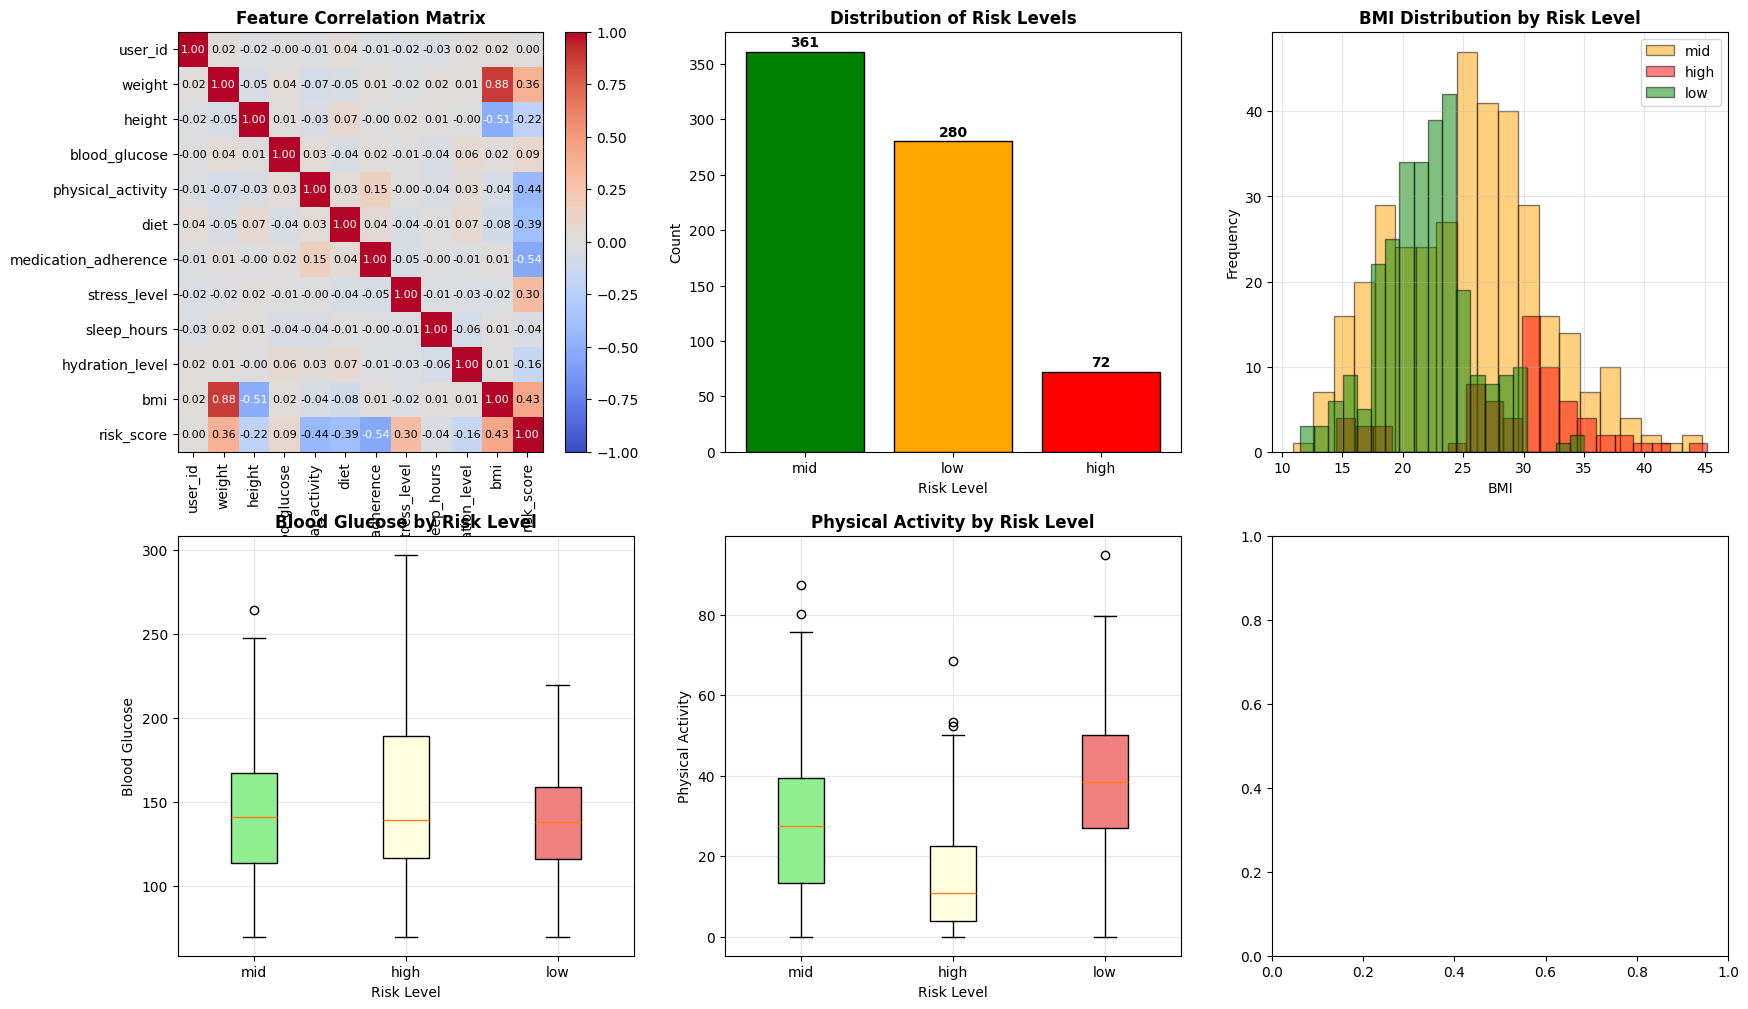

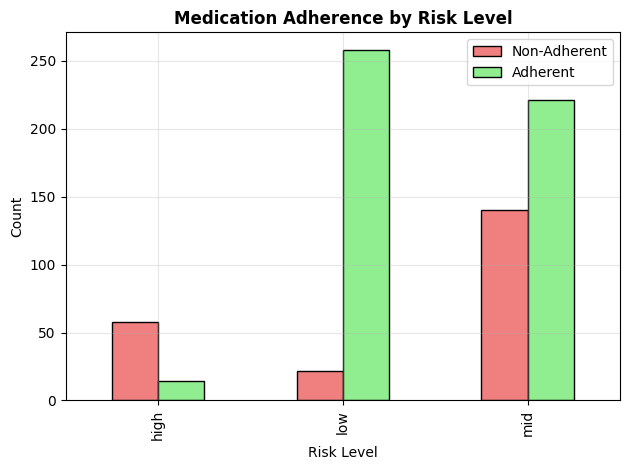


----------------------------------------
CORRELATION INSIGHTS
----------------------------------------
1. BMI has high correlation with weight and height
2. Keeping BMI only - removing weight and height to avoid multicollinearity
3. This reduces feature redundancy and improves model stability


In [20]:
# ============================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================
print("\n" + "="*60)
print("3. EXPLORATORY DATA ANALYSIS")
print("="*60)

# Create figure for EDA plots
plt.figure(figsize=(20, 12))

# 1. Correlation heatmap for all numerical features
plt.subplot(2, 3, 1)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)

# Add correlation values
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="white" if abs(correlation_matrix.iloc[i, j]) > 0.5 else "black",
                       fontsize=8)

# 2. Target variable distribution
plt.subplot(2, 3, 2)
risk_counts = df['risk_level'].value_counts()
risk_labels = risk_counts.index
risk_values = risk_counts.values
colors = ['green', 'orange', 'red']
bars = plt.bar(risk_labels, risk_values, color=colors, edgecolor='black')
plt.title('Distribution of Risk Levels', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Count')
for i, v in enumerate(risk_values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

# 3. BMI distribution by risk level
plt.subplot(2, 3, 3)
risk_levels = df['risk_level'].unique()
for risk in risk_levels:
    subset = df[df['risk_level'] == risk]
    if risk == 'low':
        color = 'green'
    elif risk == 'mid':
        color = 'orange'
    else:
        color = 'red'
    plt.hist(subset['bmi'], alpha=0.5, label=risk, color=color, bins=20, edgecolor='black')
plt.title('BMI Distribution by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Blood glucose by risk level
plt.subplot(2, 3, 4)
box_data = [df[df['risk_level'] == risk]['blood_glucose'].values for risk in risk_levels]
bp = plt.boxplot(box_data, labels=risk_levels, patch_artist=True)
colors_box = ['lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
plt.title('Blood Glucose by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Blood Glucose')
plt.grid(True, alpha=0.3)

# 5. Physical activity by risk level
plt.subplot(2, 3, 5)
box_data = [df[df['risk_level'] == risk]['physical_activity'].values for risk in risk_levels]
bp = plt.boxplot(box_data, labels=risk_levels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
plt.title('Physical Activity by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Physical Activity')
plt.grid(True, alpha=0.3)

# 6. Medication adherence by risk level
plt.subplot(2, 3, 6)
medication_by_risk = df.groupby('risk_level')['medication_adherence'].value_counts().unstack()
medication_by_risk.plot(kind='bar', color=['lightcoral', 'lightgreen'], edgecolor='black')
plt.title('Medication Adherence by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.legend(['Non-Adherent', 'Adherent'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display correlation insights
print("\n" + "-"*40)
print("CORRELATION INSIGHTS")
print("-"*40)
print("1. BMI has high correlation with weight and height")
print("2. Keeping BMI only - removing weight and height to avoid multicollinearity")
print("3. This reduces feature redundancy and improves model stability")


3. DATA PREPROCESSING WITH BALANCING
Original Class Distribution:
risk_binary
1    433
0    280
Name: count, dtype: int64

Class Ratio: 0.65:1

APPLYING SMOTE FOR BALANCING
✓ Applied SMOTE (Synthetic Minority Oversampling)

After Balancing:
Class 0 samples: 433
Class 1 samples: 433
Total samples: 866


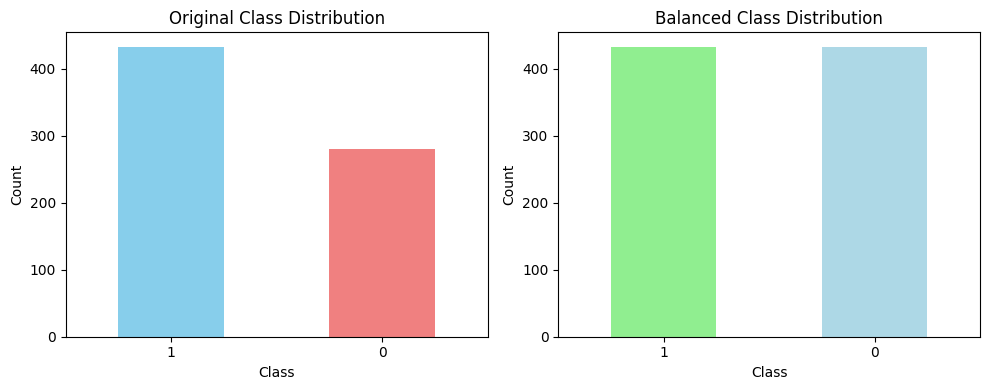


✓ Data balanced successfully!
✓ Ready for modeling with balanced classes


In [30]:
# ============================================
# 3. PREPROCESSING WITH BALANCING
# ============================================
print("\n" + "="*60)
print("3. DATA PREPROCESSING WITH BALANCING")
print("="*60)

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Check class distribution
print("Original Class Distribution:")
print(y.value_counts())
print(f"\nClass Ratio: {y.value_counts()[0]/y.value_counts()[1]:.2f}:1")

# Visualize imbalance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
y.value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Apply balancing method (choose one)

# Option 1: SMOTE (Synthetic Minority Oversampling)
print("\n" + "="*40)
print("APPLYING SMOTE FOR BALANCING")
print("="*40)
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)
print("✓ Applied SMOTE (Synthetic Minority Oversampling)")

print(f"\nAfter Balancing:")
print(f"Class 0 samples: {sum(y_balanced == 0)}")
print(f"Class 1 samples: {sum(y_balanced == 1)}")
print(f"Total samples: {len(y_balanced)}")

# Visualize balanced data
plt.subplot(1, 2, 2)
pd.Series(y_balanced).value_counts().plot(kind='bar', color=['lightgreen', 'lightblue'])
plt.title('Balanced Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Update X and y with balanced data
X_balanced_scaled = X_balanced  # Already scaled
y_balanced = y_balanced

print("\n✓ Data balanced successfully!")
print("✓ Ready for modeling with balanced classes")

In [31]:
# ============================================
# 4. TRAIN-TEST SPLIT (with balanced data)
# ============================================
print("\n" + "="*60)
print("4. TRAIN-TEST SPLIT (BALANCED DATA)")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced_scaled, y_balanced,  # Use balanced data
    test_size=0.2,
    random_state=42,
    stratify=y_balanced  # Stratify on balanced labels
)

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples:  {X_test.shape[0]}")
print(f"\nTrain Class Distribution: {np.bincount(y_train)}")
print(f"Test Class Distribution:  {np.bincount(y_test)}")
print(f"✓ Perfectly balanced split!")


4. TRAIN-TEST SPLIT (BALANCED DATA)
Train samples: 692
Test samples:  174

Train Class Distribution: [346 346]
Test Class Distribution:  [87 87]
✓ Perfectly balanced split!


In [37]:
# ============================================
# 5. ML MODEL IMPLEMENTATION (with Ensembles + ANN)
# ============================================
print("\n" + "="*60)
print("5. MODEL TRAINING - WITH ANN, BAGGING, BOOSTING, STACKING")
print("="*60)

from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier
)

# -------------------------------
# Scale the data if not already scaled
# -------------------------------
from sklearn.preprocessing import StandardScaler

# Only scale if not already done in preprocessing
if 'X_train_scaled' not in locals() and 'X_test_scaled' not in locals():
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("✓ Features scaled")
else:
    print("✓ Features already scaled")

# -------------------------------
# Base ANN model
# -------------------------------
ann_base = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# -------------------------------
# Initialize models
# -------------------------------
models = {

    # ============================
    # Base Models
    # ============================
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'ANN': ann_base,

    # ============================
    # Bagging
    # ============================
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10
    ),

    'Bagging (ANN)': BaggingClassifier(
        estimator=MLPClassifier(
            hidden_layer_sizes=(32,),
            max_iter=300,
            random_state=42
        ),
        n_estimators=10,
        random_state=42
    ),

    # ============================
    # Boosting
    # ============================
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42,
        n_estimators=100
    ),

    'AdaBoost (ANN)': AdaBoostClassifier(
        estimator=MLPClassifier(
            hidden_layer_sizes=(16,),
            max_iter=200,
            random_state=42
        ),
        n_estimators=10,
        learning_rate=0.5,
        random_state=42
    ),

    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    )
}

# ============================
# Stacking (ANN as Meta-Learner)
# ============================
stacking_model = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svm', SVC(probability=True, random_state=42))
    ],
    final_estimator=MLPClassifier(
        hidden_layer_sizes=(32, 16),
        max_iter=500,
        random_state=42
    ),
    passthrough=True
)

models['Stacking (ANN Meta-Learner)'] = stacking_model

# -------------------------------
# Training Loop
# -------------------------------
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        if name == 'XGBoost':
            model.fit(
                X_train_scaled, y_train,
                eval_set=[(X_test_scaled, y_test)],
                verbose=False
            )
        else:
            model.fit(X_train_scaled, y_train)

        trained_models[name] = model

        # Calculate training accuracy
        train_acc = model.score(X_train_scaled, y_train)
        print(f"  ✓ {name} trained | Train Acc: {train_acc:.4f}")

    except Exception as e:
        print(f"  ✗ Error training {name}: {str(e)}")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE")
print("="*60)
print(f"✓ Total models trained: {len(trained_models)}")
print(f"✓ Models include: {', '.join(trained_models.keys())}")



5. MODEL TRAINING - WITH ANN, BAGGING, BOOSTING, STACKING
Scaling features...
✓ Features scaled

Training Logistic Regression...
  ✓ Logistic Regression trained | Train Acc: 0.8439

Training Decision Tree...
  ✓ Decision Tree trained | Train Acc: 0.9176

Training SVM...
  ✓ SVM trained | Train Acc: 0.9162

Training KNN...
  ✓ KNN trained | Train Acc: 0.9003

Training Naive Bayes...
  ✓ Naive Bayes trained | Train Acc: 0.8671

Training ANN...
  ✓ ANN trained | Train Acc: 0.8526

Training Random Forest...
  ✓ Random Forest trained | Train Acc: 1.0000

Training Bagging (ANN)...
  ✓ Bagging (ANN) trained | Train Acc: 0.9205

Training Gradient Boosting...
  ✓ Gradient Boosting trained | Train Acc: 1.0000

Training AdaBoost (ANN)...
  ✗ Error training AdaBoost (ANN): MLPClassifier doesn't support sample_weight.

Training XGBoost...
  ✓ XGBoost trained | Train Acc: 1.0000

Training Stacking (ANN Meta-Learner)...
  ✓ Stacking (ANN Meta-Learner) trained | Train Acc: 1.0000

MODEL TRAINING COMP


6. MODEL EVALUATION

Evaluating Logistic Regression...


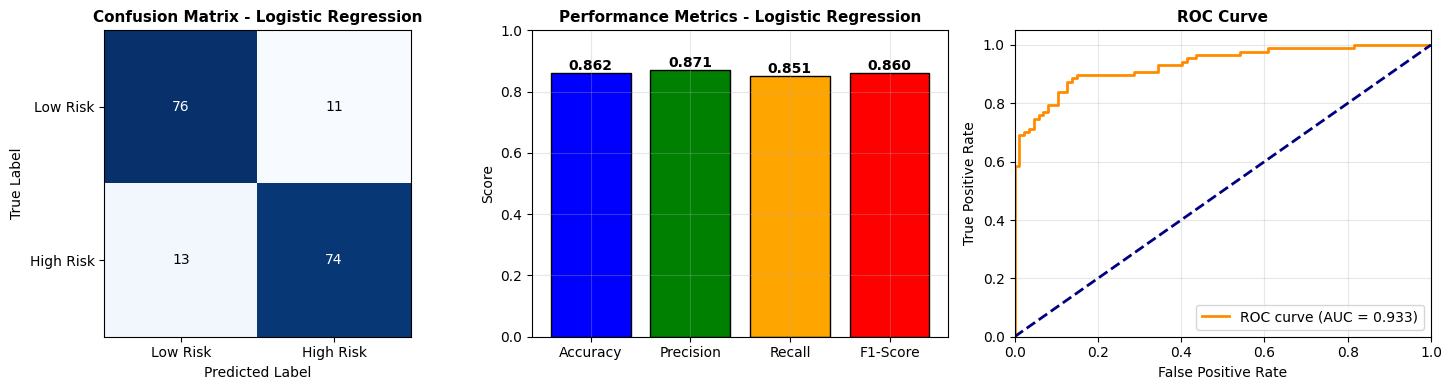

✓ Logistic Regression            | Accuracy: 0.8621 | F1-Score: 0.8605 | Type: Base
  ROC-AUC: 0.9326

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.85      0.87      0.86        87
   High Risk       0.87      0.85      0.86        87

    accuracy                           0.86       174
   macro avg       0.86      0.86      0.86       174
weighted avg       0.86      0.86      0.86       174

------------------------------------------------------------

Evaluating Decision Tree...


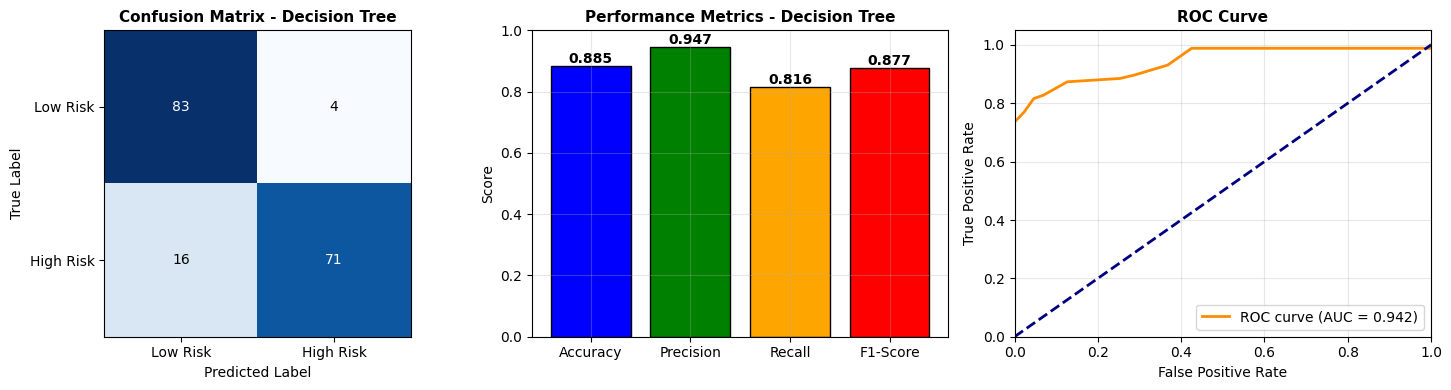

✓ Decision Tree                  | Accuracy: 0.8851 | F1-Score: 0.8765 | Type: Base
  ROC-AUC: 0.9420

Decision Tree Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.84      0.95      0.89        87
   High Risk       0.95      0.82      0.88        87

    accuracy                           0.89       174
   macro avg       0.89      0.89      0.88       174
weighted avg       0.89      0.89      0.88       174

------------------------------------------------------------

Evaluating SVM...


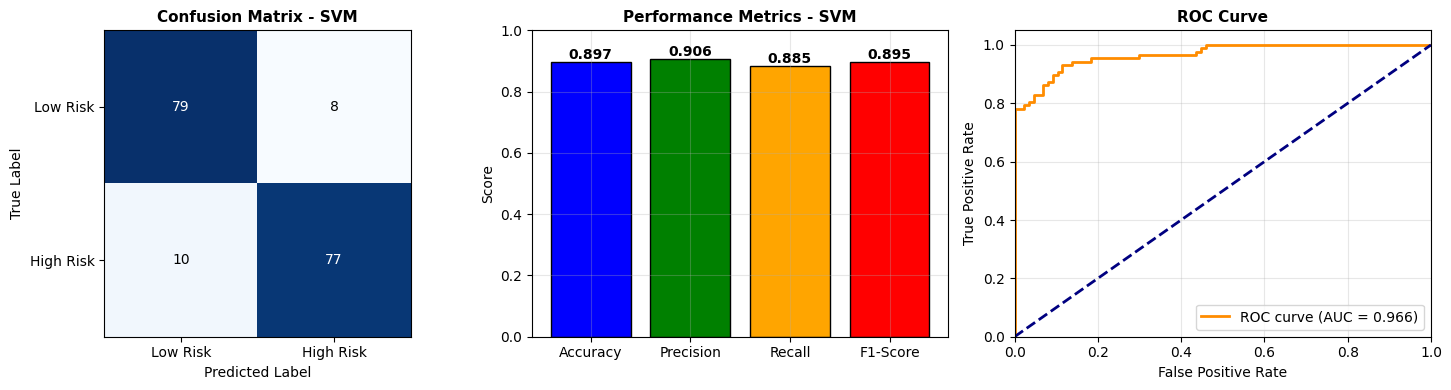

✓ SVM                            | Accuracy: 0.8966 | F1-Score: 0.8953 | Type: Base
  ROC-AUC: 0.9664

SVM Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.89      0.91      0.90        87
   High Risk       0.91      0.89      0.90        87

    accuracy                           0.90       174
   macro avg       0.90      0.90      0.90       174
weighted avg       0.90      0.90      0.90       174

------------------------------------------------------------

Evaluating KNN...


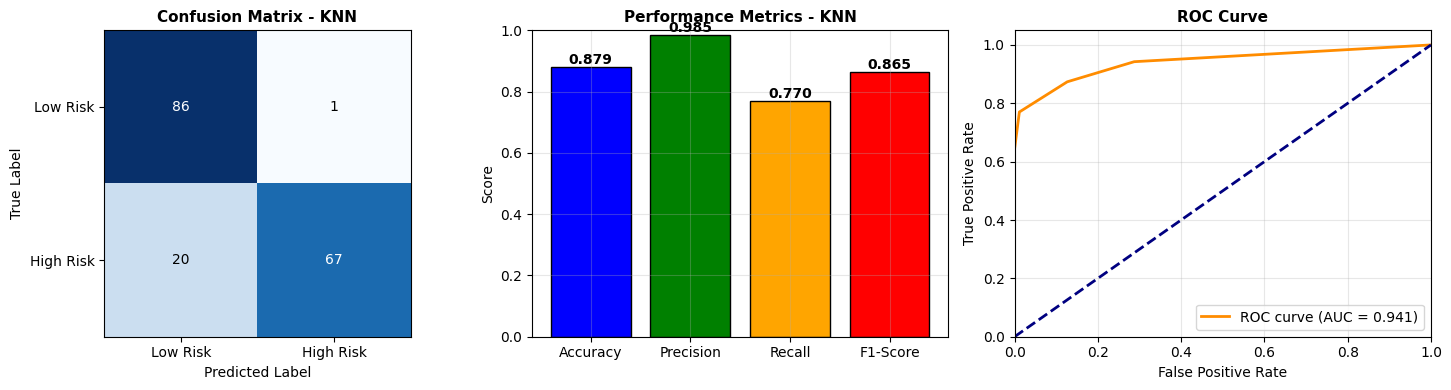

✓ KNN                            | Accuracy: 0.8793 | F1-Score: 0.8645 | Type: Base
  ROC-AUC: 0.9409

KNN Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.81      0.99      0.89        87
   High Risk       0.99      0.77      0.86        87

    accuracy                           0.88       174
   macro avg       0.90      0.88      0.88       174
weighted avg       0.90      0.88      0.88       174

------------------------------------------------------------

Evaluating Naive Bayes...


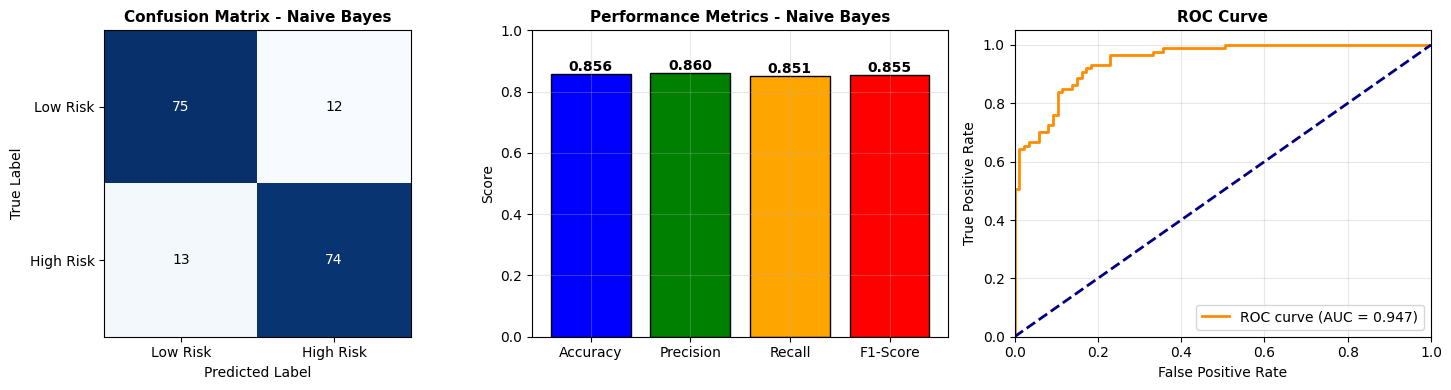

✓ Naive Bayes                    | Accuracy: 0.8563 | F1-Score: 0.8555 | Type: Base
  ROC-AUC: 0.9466

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.85      0.86      0.86        87
   High Risk       0.86      0.85      0.86        87

    accuracy                           0.86       174
   macro avg       0.86      0.86      0.86       174
weighted avg       0.86      0.86      0.86       174

------------------------------------------------------------

Evaluating ANN...


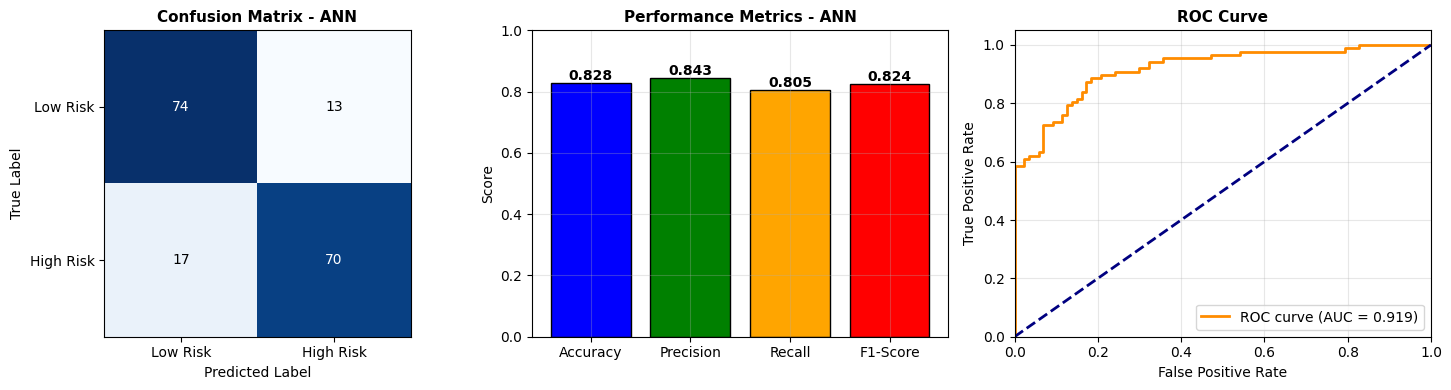

✓ ANN                            | Accuracy: 0.8276 | F1-Score: 0.8235 | Type: Neural Network
  ROC-AUC: 0.9186

ANN Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.81      0.85      0.83        87
   High Risk       0.84      0.80      0.82        87

    accuracy                           0.83       174
   macro avg       0.83      0.83      0.83       174
weighted avg       0.83      0.83      0.83       174

------------------------------------------------------------

Evaluating Random Forest...


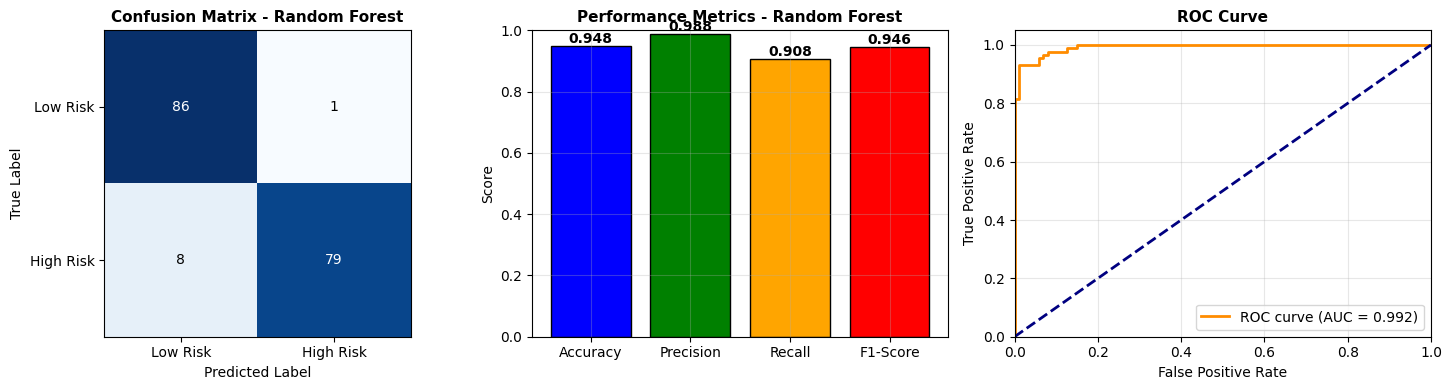

✓ Random Forest                  | Accuracy: 0.9483 | F1-Score: 0.9461 | Type: Ensemble
  ROC-AUC: 0.9925

Random Forest Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.91      0.99      0.95        87
   High Risk       0.99      0.91      0.95        87

    accuracy                           0.95       174
   macro avg       0.95      0.95      0.95       174
weighted avg       0.95      0.95      0.95       174

------------------------------------------------------------

Evaluating Bagging (ANN)...


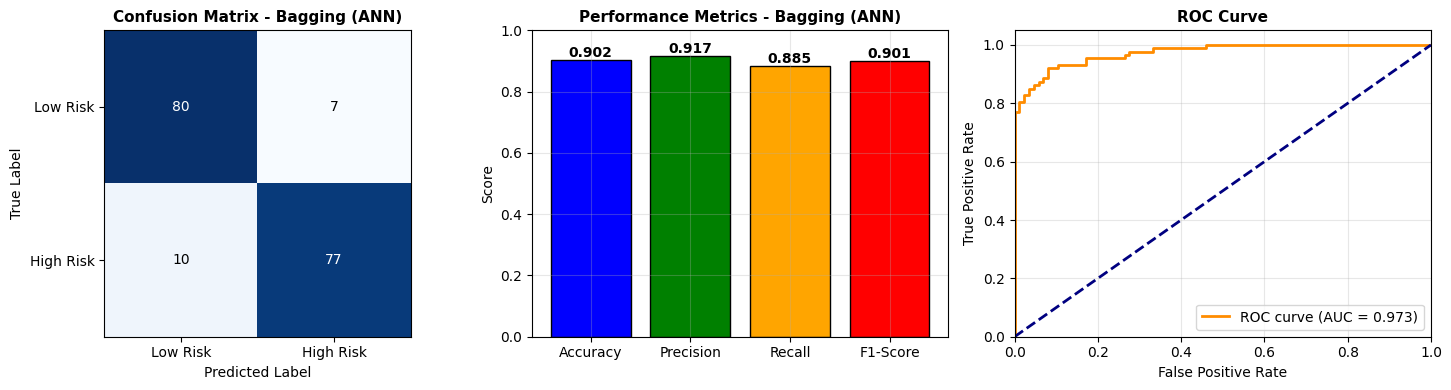

✓ Bagging (ANN)                  | Accuracy: 0.9023 | F1-Score: 0.9006 | Type: Neural Network
  ROC-AUC: 0.9730

Bagging (ANN) Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.89      0.92      0.90        87
   High Risk       0.92      0.89      0.90        87

    accuracy                           0.90       174
   macro avg       0.90      0.90      0.90       174
weighted avg       0.90      0.90      0.90       174

------------------------------------------------------------

Evaluating Gradient Boosting...


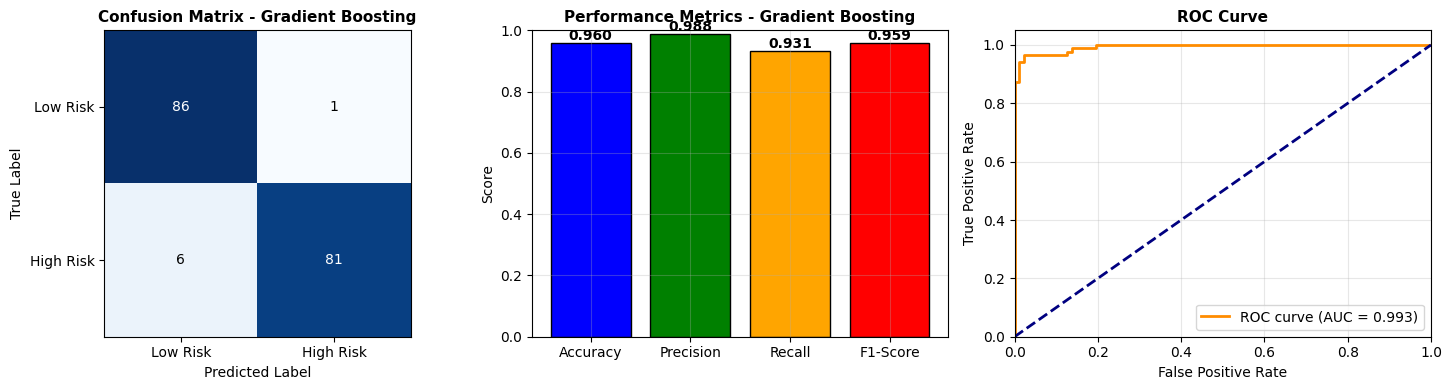

✓ Gradient Boosting              | Accuracy: 0.9598 | F1-Score: 0.9586 | Type: Ensemble
  ROC-AUC: 0.9934

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.93      0.99      0.96        87
   High Risk       0.99      0.93      0.96        87

    accuracy                           0.96       174
   macro avg       0.96      0.96      0.96       174
weighted avg       0.96      0.96      0.96       174

------------------------------------------------------------

Evaluating XGBoost...


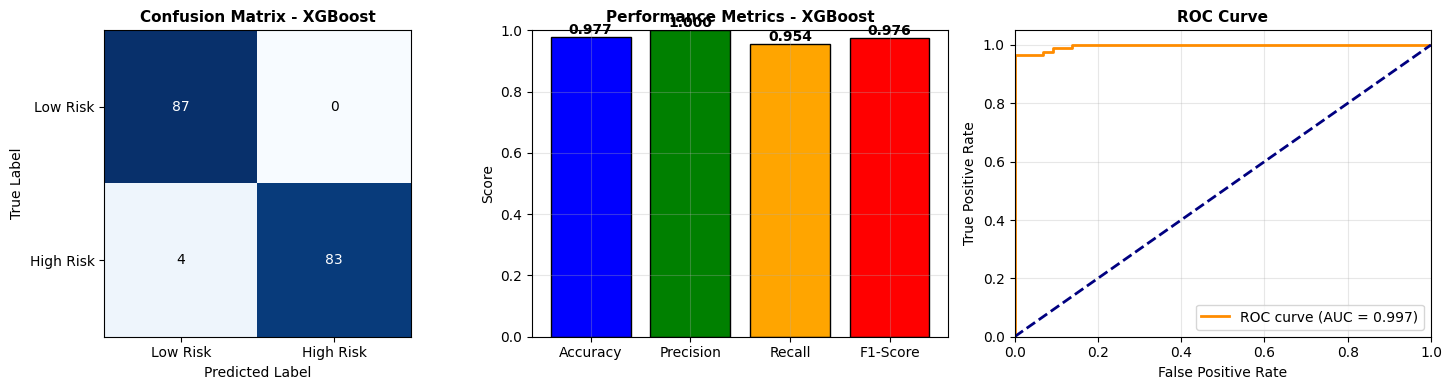

✓ XGBoost                        | Accuracy: 0.9770 | F1-Score: 0.9765 | Type: Ensemble
  ROC-AUC: 0.9966

XGBoost Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.96      1.00      0.98        87
   High Risk       1.00      0.95      0.98        87

    accuracy                           0.98       174
   macro avg       0.98      0.98      0.98       174
weighted avg       0.98      0.98      0.98       174

------------------------------------------------------------

Evaluating Stacking (ANN Meta-Learner)...


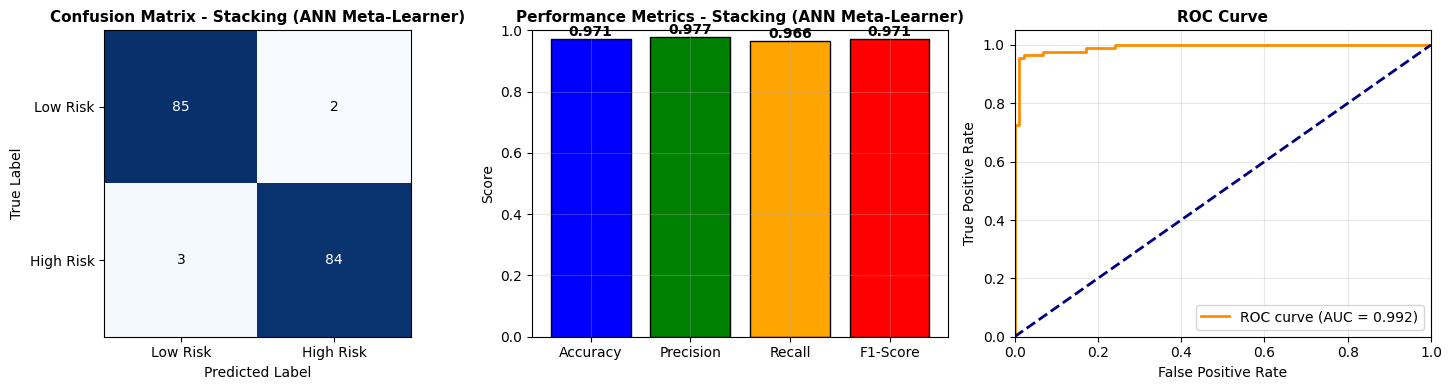

✓ Stacking (ANN Meta-Learner)    | Accuracy: 0.9713 | F1-Score: 0.9711 | Type: Neural Network
  ROC-AUC: 0.9915

Stacking (ANN Meta-Learner) Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.97      0.98      0.97        87
   High Risk       0.98      0.97      0.97        87

    accuracy                           0.97       174
   macro avg       0.97      0.97      0.97       174
weighted avg       0.97      0.97      0.97       174

------------------------------------------------------------

MODEL PERFORMANCE COMPARISON
                      Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC           Type
                    XGBoost  0.977011   1.000000 0.954023  0.976471 0.996565       Ensemble
Stacking (ANN Meta-Learner)  0.971264   0.976744 0.965517  0.971098 0.991544 Neural Network
          Gradient Boosting  0.959770   0.987805 0.931034  0.958580 0.993394       Ensemble
              Random Forest  0.948276   0.987500 0

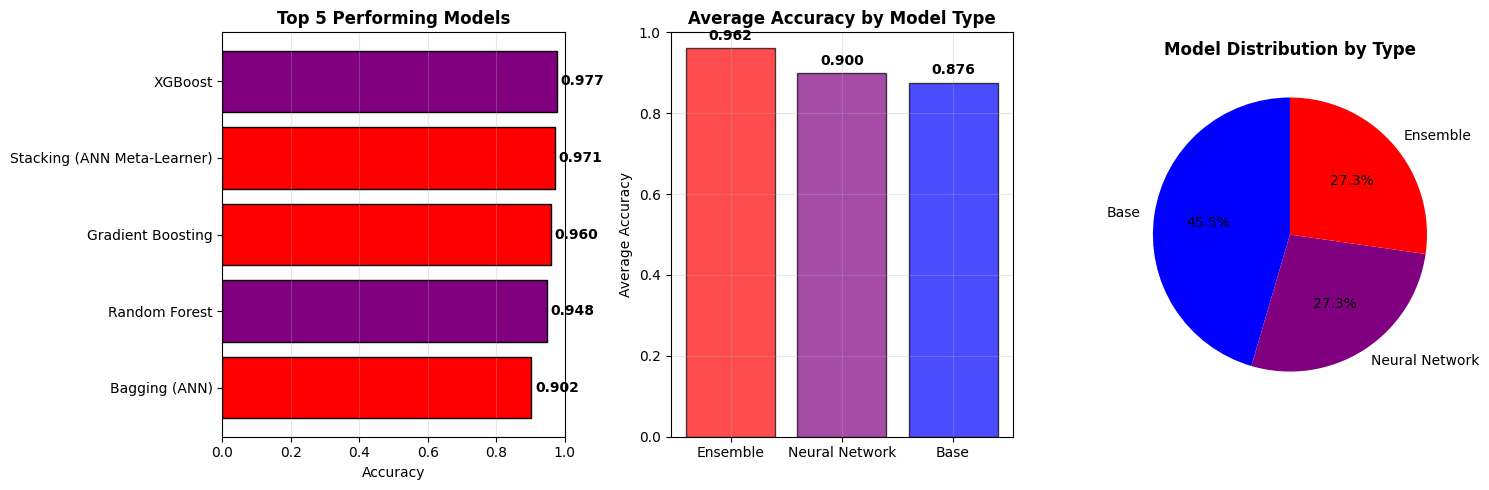


MODEL TYPE ANALYSIS

Base Models (5 models):
  Average Accuracy: 0.8759
  Average F1-Score: 0.8705
  Best Accuracy: 0.8966
  Worst Accuracy: 0.8563
    - SVM                           : 0.8966
    - Decision Tree                 : 0.8851
    - KNN                           : 0.8793
    - Logistic Regression           : 0.8621
    - Naive Bayes                   : 0.8563

Neural Network Models (3 models):
  Average Accuracy: 0.9004
  Average F1-Score: 0.8984
  Best Accuracy: 0.9713
  Worst Accuracy: 0.8276
    - Stacking (ANN Meta-Learner)   : 0.9713
    - Bagging (ANN)                 : 0.9023
    - ANN                           : 0.8276

Ensemble Models (3 models):
  Average Accuracy: 0.9617
  Average F1-Score: 0.9604
  Best Accuracy: 0.9770
  Worst Accuracy: 0.9483
    - XGBoost                       : 0.9770
    - Gradient Boosting             : 0.9598
    - Random Forest                 : 0.9483

----------------------------------------
PERFORMANCE COMPARISON
---------------------

In [38]:
# ============================================
# 6. MODEL EVALUATION
# ============================================
print("\n" + "="*60)
print("6. MODEL EVALUATION")
print("="*60)

def evaluate_model(model, X_test, y_test, model_name):
    try:
        y_pred = model.predict(X_test)

        # Handle models that don't have predict_proba
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            # For SVM without probability=True
            y_pred_proba = model.decision_function(X_test)
            # Scale to [0, 1] for ROC-AUC
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        else:
            y_pred_proba = None

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Calculate ROC-AUC if possible
        if y_pred_proba is not None and len(np.unique(y_test)) > 1:
            try:
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            except:
                roc_auc = None
        else:
            roc_auc = None

        # Determine model type
        ensemble_keywords = ['Random Forest', 'Bagging', 'Gradient Boosting',
                            'AdaBoost', 'XGBoost', 'Voting', 'Stacking', 'Ensemble']
        nn_keywords = ['ANN', 'Neural Network', 'MLP']

        if any(keyword in model_name for keyword in nn_keywords):
            model_type = 'Neural Network'
        elif any(keyword in model_name for keyword in ensemble_keywords):
            model_type = 'Ensemble'
        else:
            model_type = 'Base'

        metrics = {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'Type': model_type
        }

        return metrics, y_pred, y_pred_proba

    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        return None, None, None


# Evaluate all models
results = []
predictions = {}
failed_models = []

for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")
    try:
        metrics, y_pred, y_pred_proba = evaluate_model(model, X_test_scaled, y_test, name)

        if metrics is not None:
            results.append(metrics)
            predictions[name] = (y_pred, y_pred_proba)

            # Create evaluation visualization for each model
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            axes[0].set_title(f'Confusion Matrix - {name}', fontsize=11, fontweight='bold')
            axes[0].set_xticks([0, 1])
            axes[0].set_yticks([0, 1])
            axes[0].set_xticklabels(['Low Risk', 'High Risk'])
            axes[0].set_yticklabels(['Low Risk', 'High Risk'])
            axes[0].set_ylabel('True Label')
            axes[0].set_xlabel('Predicted Label')

            # Add text annotations
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    axes[0].text(j, i, format(cm[i, j], 'd'),
                                 ha="center", va="center",
                                 color="white" if cm[i, j] > thresh else "black")

            # Metrics bar chart
            metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
            metric_values = [
                metrics['Accuracy'],
                metrics['Precision'],
                metrics['Recall'],
                metrics['F1-Score']
            ]
            colors = ['blue', 'green', 'orange', 'red']

            bars = axes[1].bar(metric_names, metric_values, color=colors, edgecolor='black')
            axes[1].set_title(f'Performance Metrics - {name}', fontsize=11, fontweight='bold')
            axes[1].set_ylabel('Score')
            axes[1].set_ylim([0, 1])
            axes[1].grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, value in zip(bars, metric_values):
                height = bar.get_height()
                axes[1].text(bar.get_x() + bar.get_width()/2., height,
                             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

            # ROC Curve (if available)
            if metrics['ROC-AUC'] is not None:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                axes[2].plot(fpr, tpr, color='darkorange', lw=2,
                           label=f'ROC curve (AUC = {metrics["ROC-AUC"]:.3f})')
                axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                axes[2].set_xlim([0.0, 1.0])
                axes[2].set_ylim([0.0, 1.05])
                axes[2].set_xlabel('False Positive Rate')
                axes[2].set_ylabel('True Positive Rate')
                axes[2].set_title('ROC Curve', fontsize=11, fontweight='bold')
                axes[2].legend(loc="lower right")
                axes[2].grid(True, alpha=0.3)
            else:
                axes[2].text(0.5, 0.5, 'ROC-AUC\nNot Available',
                           ha='center', va='center', fontsize=12)
                axes[2].set_title('ROC Curve', fontsize=11, fontweight='bold')
                axes[2].axis('off')

            plt.tight_layout()
            plt.show()

            print(f"✓ {name:30} | Accuracy: {metrics['Accuracy']:.4f} | F1-Score: {metrics['F1-Score']:.4f} | Type: {metrics['Type']}")

            if metrics['ROC-AUC'] is not None:
                print(f"  ROC-AUC: {metrics['ROC-AUC']:.4f}")

            print(f"\n{name} Classification Report:")
            print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk'], zero_division=0))
            print("-" * 60)
        else:
            failed_models.append(name)

    except Exception as e:
        print(f"✗ Error evaluating {name}: {str(e)}")
        failed_models.append(name)


# Convert results to DataFrame
if results:
    results_df = pd.DataFrame(results)

    print("\n" + "="*60)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*60)

    # Sort by Accuracy, handle NaN values
    results_df_sorted = results_df.sort_values('Accuracy', ascending=False, na_position='last')
    print(results_df_sorted.to_string(index=False))

    if failed_models:
        print(f"\n⚠ Models that failed evaluation: {', '.join(failed_models)}")
else:
    print("✗ No models were successfully evaluated!")
    results_df = pd.DataFrame()


# ============================================
# 6.5 IDENTIFY BEST PERFORMING MODEL
# ============================================
if not results_df.empty:
    print("\n" + "="*60)
    print("BEST MODEL ANALYSIS")
    print("="*60)

    # Find best model by Accuracy
    best_model_row = results_df.loc[results_df['Accuracy'].idxmax()]
    best_model_name = best_model_row['Model']
    best_model = trained_models[best_model_name]

    print(f"\n🏆 BEST OVERALL MODEL: {best_model_name}")
    print(f"   Accuracy:  {best_model_row['Accuracy']:.4f}")
    print(f"   F1-Score:  {best_model_row['F1-Score']:.4f}")
    # Fix for ValueError: Invalid format specifier
    roc_auc_display = f"{best_model_row['ROC-AUC']:.4f}" if best_model_row['ROC-AUC'] is not None else 'N/A'
    print(f"   ROC-AUC:   {roc_auc_display}")
    print(f"   Type:      {best_model_row['Type']}")

    print("\n" + "-"*40)
    print("TOP 3 MODELS IN MY IMPLEMENTATION")
    print("-"*40)

    top_3 = results_df.nlargest(3, 'Accuracy')[['Model', 'Accuracy', 'Type']]
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"{medal} {row['Model']:30} {row['Accuracy']:.4f} ({row['Type']})")

    # Find best model by Type
    best_by_type = {}
    for model_type in results_df['Type'].unique():
        type_df = results_df[results_df['Type'] == model_type]
        if not type_df.empty:
            best_in_type = type_df.loc[type_df['Accuracy'].idxmax()]
            best_by_type[model_type] = best_in_type

    print("\n" + "-"*40)
    print("BEST MODEL BY TYPE")
    print("-"*40)
    for model_type, best_row in best_by_type.items():
        print(f"📊 {model_type:20}: {best_row['Model']:30} (Accuracy: {best_row['Accuracy']:.4f})")


    # Visualize comparisons
    plt.figure(figsize=(15, 5))

    # Subplot 1: Top 5 models
    plt.subplot(1, 3, 1)
    top_5 = results_df.nlargest(5, 'Accuracy')

    # Define colors by type
    type_colors = {'Base': 'blue', 'Ensemble': 'red', 'Neural Network': 'purple'}
    bar_colors = [type_colors.get(t, 'gray') for t in top_5['Type']]

    bars = plt.barh(top_5['Model'][::-1], top_5['Accuracy'][::-1],
                    color=bar_colors, edgecolor='black')
    plt.xlabel('Accuracy')
    plt.title('Top 5 Performing Models', fontweight='bold', fontsize=12)
    plt.xlim([0, 1])
    plt.grid(True, alpha=0.3, axis='x')

    for bar, acc in zip(bars, top_5['Accuracy'][::-1]):
        plt.text(acc + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{acc:.3f}', va='center', fontweight='bold')

    # Subplot 2: Performance by Type
    plt.subplot(1, 3, 2)
    type_avg = results_df.groupby('Type')['Accuracy'].mean().sort_values(ascending=False)

    colors = []
    for t in type_avg.index:
        if t == 'Neural Network':
            colors.append('purple')
        elif t == 'Ensemble':
            colors.append('red')
        else:
            colors.append('blue')

    bars = plt.bar(type_avg.index, type_avg.values, color=colors,
                   alpha=0.7, edgecolor='black')
    plt.ylabel('Average Accuracy')
    plt.title('Average Accuracy by Model Type', fontweight='bold', fontsize=12)
    plt.ylim([0, 1])
    plt.grid(True, alpha=0.3)

    for i, (type_name, avg) in enumerate(type_avg.items()):
        plt.text(i, avg + 0.02, f'{avg:.3f}', ha='center', fontweight='bold')

    # Subplot 3: Model Count by Type
    plt.subplot(1, 3, 3)
    type_counts = results_df['Type'].value_counts()

    colors = []
    for t in type_counts.index:
        if t == 'Neural Network':
            colors.append('purple')
        elif t == 'Ensemble':
            colors.append('red')
        else:
            colors.append('blue')

    plt.pie(type_counts.values, labels=type_counts.index, colors=colors,
            autopct='%1.1f%%', startangle=90)
    plt.title('Model Distribution by Type', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Detailed analysis by model type
    print("\n" + "="*60)
    print("MODEL TYPE ANALYSIS")
    print("="*60)

    for model_type in results_df['Type'].unique():
        type_df = results_df[results_df['Type'] == model_type]
        if not type_df.empty:
            print(f"\n{model_type} Models ({len(type_df)} models):")
            print(f"  Average Accuracy: {type_df['Accuracy'].mean():.4f}")
            print(f"  Average F1-Score: {type_df['F1-Score'].mean():.4f}")
            print(f"  Best Accuracy: {type_df['Accuracy'].max():.4f}")
            print(f"  Worst Accuracy: {type_df['Accuracy'].min():.4f}")

            # Show models in this type sorted by accuracy
            sorted_type = type_df.sort_values('Accuracy', ascending=False)
            for _, row in sorted_type.iterrows():
                print(f"    - {row['Model']:30}: {row['Accuracy']:.4f}")

    # Compare Neural Network vs Ensemble vs Base
    if 'Neural Network' in results_df['Type'].values:
        nn_avg = results_df[results_df['Type'] == 'Neural Network']['Accuracy'].mean()
        ensemble_avg = results_df[results_df['Type'] == 'Ensemble']['Accuracy'].mean()
        base_avg = results_df[results_df['Type'] == 'Base']['Accuracy'].mean()

        print("\n" + "-"*40)
        print("PERFORMANCE COMPARISON")
        print("-"*40)
        print(f"Neural Network Average: {nn_avg:.4f}")
        print(f"Ensemble Average:       {ensemble_avg:.4f}")
        print(f"Base Average:           {base_avg:.4f}")

        if ensemble_avg > base_avg:
            improvement = ((ensemble_avg - base_avg) / base_avg) * 100
            print(f"✓ Ensemble methods are {improvement:.1f}% better than Base models")

        if nn_avg > base_avg:
            improvement = ((nn_avg - base_avg) / base_avg) * 100
            print(f"✓ Neural Networks are {improvement:.1f}% better than Base models")

    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"Total Models Tested: {len(results_df)}")
    print(f"Successfully Evaluated: {len(results_df)}")
    print(f"Failed Evaluations: {len(failed_models)}")

    if failed_models:
        print(f"Failed Models: {', '.join(failed_models)}")

    print(f"\n🏆 Best Overall Model: {best_model_name}")
    print(f"   Accuracy: {best_model_row['Accuracy']:.4f}")
    print(f"   Type: {best_model_row['Type']}")

    # Model type distribution
    type_dist = results_df['Type'].value_counts()
    print("\nModel Type Distribution:")
    for model_type, count in type_dist.items():
        print(f"  {model_type}: {count} models")

    print("="*60)

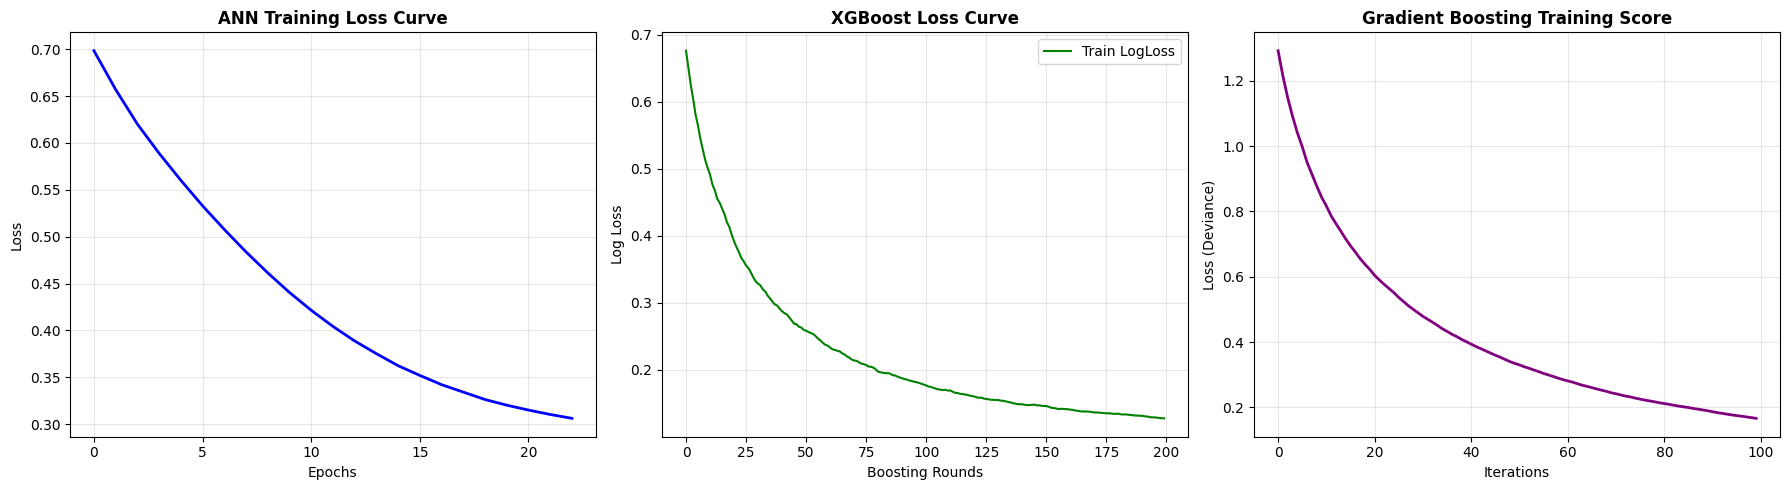

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a figure for all loss curves
plt.figure(figsize=(18, 5))

# 1. Loss Curve for ANN
plt.subplot(1, 3, 1)
if hasattr(models['ANN'], 'loss_curve_'):
    plt.plot(models['ANN'].loss_curve_, color='blue', lw=2)
    plt.title('ANN Training Loss Curve', fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

# 2. Loss Curve for XGBoost
plt.subplot(1, 3, 2)
# Ensure the XGBoost model was trained with an evaluation set to capture history
xgb_model = models['XGBoost']
if hasattr(xgb_model, 'evals_result_'):
    results = xgb_model.evals_result()
    if 'validation_0' in results:
        plt.plot(results['validation_0']['logloss'], label='Train LogLoss', color='green')
    if 'validation_1' in results:
        plt.plot(results['validation_1']['logloss'], label='Val LogLoss', color='red')
    plt.title('XGBoost Loss Curve', fontweight='bold')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 3. Loss Curve for Gradient Boosting
plt.subplot(1, 3, 3)
gb_model = models['Gradient Boosting']
if hasattr(gb_model, 'train_score_'):
    plt.plot(gb_model.train_score_, color='purple', lw=2)
    plt.title('Gradient Boosting Training Score', fontweight='bold')
    plt.xlabel('Iterations')
    plt.ylabel('Loss (Deviance)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

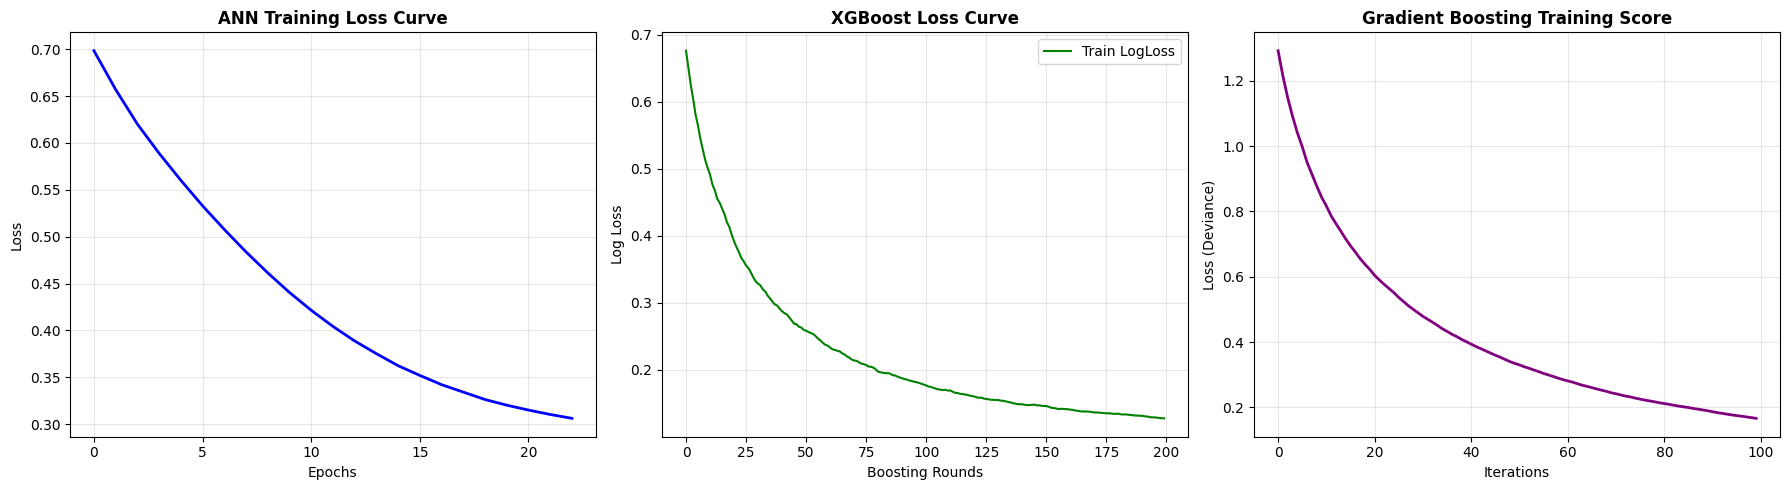

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a figure for all loss curves
plt.figure(figsize=(18, 5))

# 1. Loss Curve for ANN
plt.subplot(1, 3, 1)
if hasattr(models['ANN'], 'loss_curve_'):
    plt.plot(models['ANN'].loss_curve_, color='blue', lw=2)
    plt.title('ANN Training Loss Curve', fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

# 2. Loss Curve for XGBoost
plt.subplot(1, 3, 2)
# Ensure the XGBoost model was trained with an evaluation set to capture history
xgb_model = models['XGBoost']
if hasattr(xgb_model, 'evals_result_'):
    results = xgb_model.evals_result()
    if 'validation_0' in results:
        plt.plot(results['validation_0']['logloss'], label='Train LogLoss', color='green')
    if 'validation_1' in results:
        plt.plot(results['validation_1']['logloss'], label='Val LogLoss', color='red')
    plt.title('XGBoost Loss Curve', fontweight='bold')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 3. Loss Curve for Gradient Boosting
plt.subplot(1, 3, 3)
gb_model = models['Gradient Boosting']
if hasattr(gb_model, 'train_score_'):
    plt.plot(gb_model.train_score_, color='purple', lw=2)
    plt.title('Gradient Boosting Training Score', fontweight='bold')
    plt.xlabel('Iterations')
    plt.ylabel('Loss (Deviance)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


8. BEST MODEL ANALYSIS

Best Model: XGBoost
Accuracy: 0.9770
F1-Score: 0.9765

Cross-Validation Results for XGBoost:
Scores: [0.9352518  0.92805755 0.92753623 0.93478261 0.97101449]
Mean CV Accuracy: 0.9393 (+/- 0.0323)

----------------------------------------
FEATURE IMPORTANCE (Best Model)
----------------------------------------
                Feature  Importance
3  medication_adherence    0.282907
2                  diet    0.171534
7                   bmi    0.143820
4          stress_level    0.130263
1     physical_activity    0.092727
6       hydration_level    0.082136
0         blood_glucose    0.052137
5           sleep_hours    0.044477


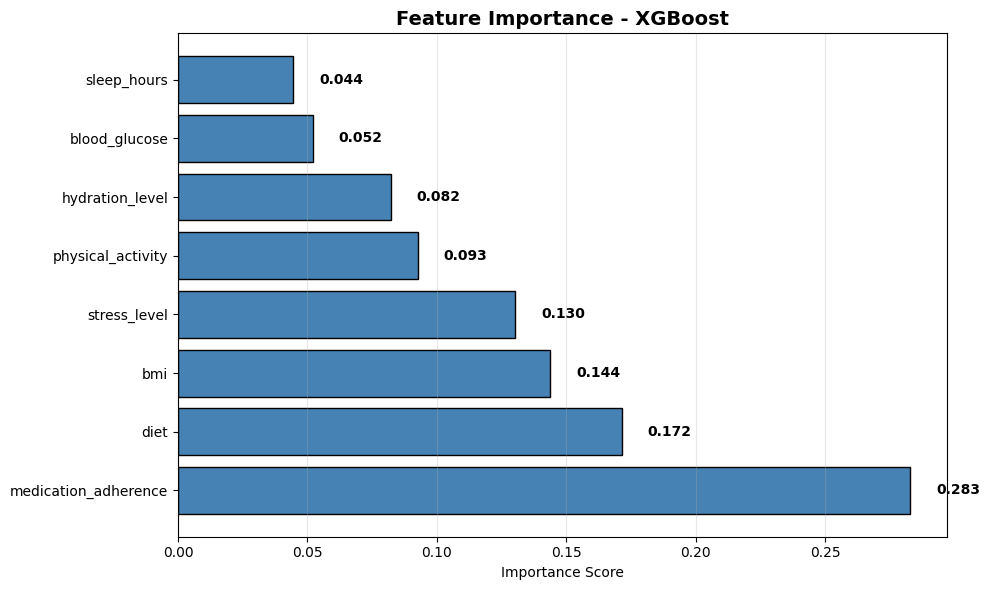


✓ Best model and scaler saved to disk


In [42]:
# ============================================
# 8. BEST MODEL ANALYSIS AND DEPLOYMENT
# ============================================
print("\n" + "="*60)
print("8. BEST MODEL ANALYSIS")
print("="*60)

# Identify best model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model = trained_models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']:.4f}")
print(f"F1-Score: {results_df.loc[results_df['Accuracy'].idxmax(), 'F1-Score']:.4f}")

# Cross-validation for best model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Results for {best_model_name}:")
print(f"Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Feature importance for best model
if hasattr(best_model, 'feature_importances_'):
    print("\n" + "-"*40)
    print("FEATURE IMPORTANCE (Best Model)")
    print("-"*40)
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_importance_df)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(feature_importance_df)),
                    feature_importance_df['Importance'],
                    color='steelblue', edgecolor='black')
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, imp) in enumerate(zip(bars, feature_importance_df['Importance'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{imp:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Save the best model
import joblib
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n✓ Best model and scaler saved to disk")




9. PREDICTION FUNCTION

Example Prediction (using optimized features):

Prediction Result:
Risk Prediction: High Risk
Confidence: 0.9019778966903687
Low Risk Probability: 0.09802210330963135
High Risk Probability: 0.9019778966903687

----------------------------------------
FEATURE CONTRIBUTIONS TO PREDICTION
----------------------------------------


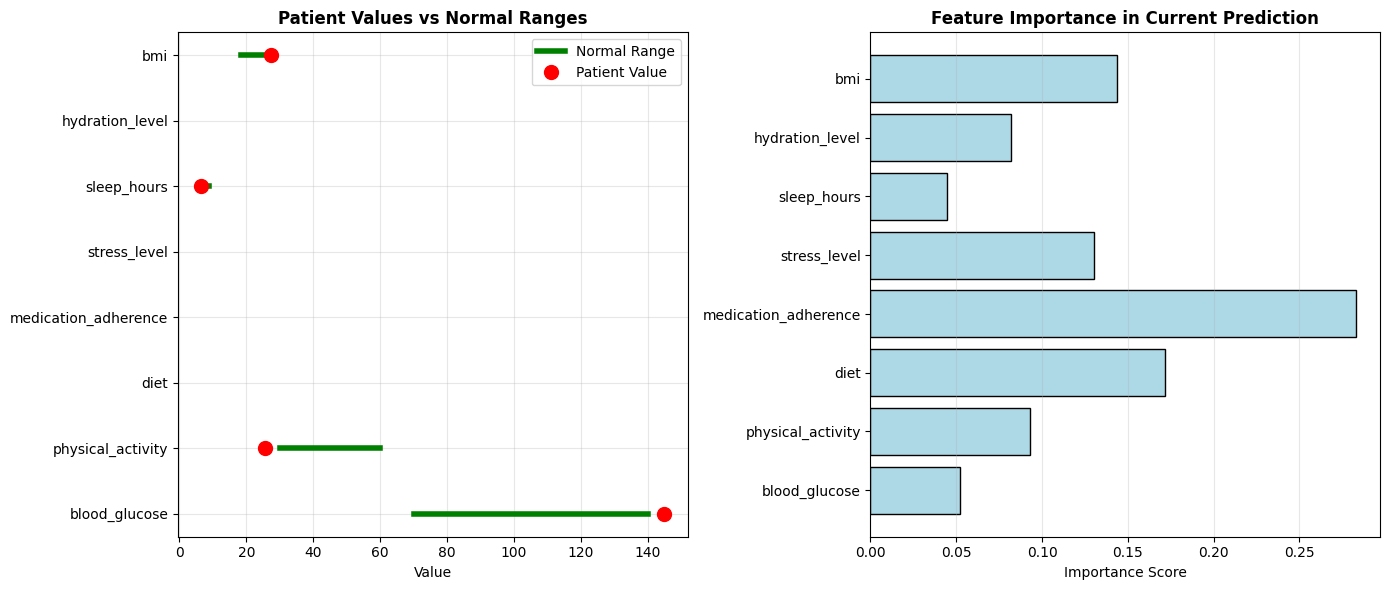


ML PIPELINE COMPLETED SUCCESSFULLY!

Key Improvements:
1. Removed weight and height (redundant with BMI)
2. Reduced multicollinearity
3. Used 8 optimized features instead of 10
4. Best Model: XGBoost
5. Test Accuracy: 0.9770

Models available for use:
  - Logistic Regression
  - Decision Tree
  - SVM
  - KNN
  - Naive Bayes
  - ANN
  - Random Forest
  - Bagging (ANN)
  - Gradient Boosting
  - XGBoost
  - Stacking (ANN Meta-Learner)


In [43]:
# ============================================
# 9. PREDICTION FUNCTION WITH NEW FEATURES
# ============================================
print("\n" + "="*60)
print("9. PREDICTION FUNCTION")
print("="*60)

def predict_diabetes_risk(bmi, blood_glucose, physical_activity,
                         diet, medication_adherence, stress_level,
                         sleep_hours, hydration_level):
    """
    Predict diabetes risk using optimized feature set
    Note: weight and height removed to avoid multicollinearity with BMI
    """
    # Prepare input array in the correct order
    input_data = np.array([[
        blood_glucose, physical_activity, diet,
        medication_adherence, stress_level, sleep_hours,
        hydration_level, bmi
    ]])

    # Scale input
    input_scaled = scaler.transform(input_data)

    # Get prediction
    prediction = best_model.predict(input_scaled)[0]
    probability = best_model.predict_proba(input_scaled)[0]

    risk_level = "Low Risk" if prediction == 0 else "High Risk"
    confidence = probability[prediction]

    # Get feature importance if available
    feature_contributions = {}
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        for i, feature in enumerate(feature_names):
            feature_contributions[feature] = {
                'value': input_data[0, i],
                'importance': importances[i]
            }

    return {
        'risk_prediction': risk_level,
        'confidence': float(confidence),
        'low_risk_probability': float(probability[0]),
        'high_risk_probability': float(probability[1]),
        'feature_contributions': feature_contributions if feature_contributions else None
    }

# Example usage
print("\nExample Prediction (using optimized features):")
example_result = predict_diabetes_risk(
    bmi=27.5,
    blood_glucose=145,
    physical_activity=25.5,
    diet=1,
    medication_adherence=1,
    stress_level=2,
    sleep_hours=6.5,
    hydration_level=1
)

print("\nPrediction Result:")
for key, value in example_result.items():
    if key != 'feature_contributions':
        print(f"{key.replace('_', ' ').title()}: {value}")

# Visualize prediction with feature contributions
if example_result['feature_contributions']:
    print("\n" + "-"*40)
    print("FEATURE CONTRIBUTIONS TO PREDICTION")
    print("-"*40)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart of feature values vs normal ranges
    axes[0].set_title('Patient Values vs Normal Ranges', fontsize=12, fontweight='bold')

    # Normal ranges for features (example values)
    normal_ranges = {
        'bmi': (18.5, 24.9),
        'blood_glucose': (70, 140),
        'physical_activity': (30, 60),
        'sleep_hours': (7, 9)
    }

    for i, (feature, data) in enumerate(example_result['feature_contributions'].items()):
        if feature in normal_ranges:
            low, high = normal_ranges[feature]
            axes[0].plot([low, high], [i, i], 'g-', linewidth=4, label='Normal Range' if i==0 else "")
            axes[0].plot(data['value'], i, 'ro', markersize=10, label='Patient Value' if i==0 else "")

    axes[0].set_yticks(range(len(example_result['feature_contributions'])))
    axes[0].set_yticklabels(list(example_result['feature_contributions'].keys()))
    axes[0].set_xlabel('Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Feature importance in prediction
    axes[1].set_title('Feature Importance in Current Prediction', fontsize=12, fontweight='bold')
    features = list(example_result['feature_contributions'].keys())
    importances = [data['importance'] for data in example_result['feature_contributions'].values()]

    bars = axes[1].barh(features, importances, color='lightblue', edgecolor='black')
    axes[1].set_xlabel('Importance Score')
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("ML PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nKey Improvements:")
print(f"1. Removed weight and height (redundant with BMI)")
print(f"2. Reduced multicollinearity")
print(f"3. Used 8 optimized features instead of 10")
print(f"4. Best Model: {best_model_name}")
print(f"5. Test Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']:.4f}")
print("\nModels available for use:")
for name in trained_models.keys():
    print(f"  - {name}")
print("="*60)